<a href="https://colab.research.google.com/github/edahg/competitive-data-science/blob/master/Sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sales Prediction** 

This notebook was executed on Google Colab

## **Install needed modules**

In [1]:
!pip install category_encoders
!pip install xgboost
!pip install seaborn

     |████████████████████████████████| 81kB 2.4MB/s 


In [2]:
import pandas as pd
import numpy as np

from itertools import product
import category_encoders as ce

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import plot_importance

import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)
%cd 'drive/My Drive/Colab Notebooks/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


## **Load Data**

In [ ]:
sales_train_df = pd.read_csv('sales_train.csv')
test_df = pd.read_csv('test.csv')
items_df = pd.read_csv('items.csv')
shops_df = pd.read_csv('shops.csv')
categories_df = pd.read_csv('item_categories.csv')

## **EDA**

### Shops Data
The first word of shop name corresponds to the city. 

In [ ]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
#extract city from shop_name
shops_df['city'] = shops_df.shop_name.str.split(expand=True)[0]
shops_df['city'].unique()

0              !Якутск
1              !Якутск
2               Адыгея
3             Балашиха
4             Волжский
5              Вологда
6              Воронеж
7              Воронеж
8              Воронеж
9             Выездная
10           Жуковский
11           Жуковский
12    Интернет-магазин
13              Казань
14              Казань
15              Калуга
16             Коломна
17          Красноярск
18          Красноярск
19               Курск
20              Москва
21              Москва
22              Москва
23              Москва
24              Москва
25              Москва
26              Москва
27              Москва
28              Москва
29              Москва
30              Москва
31              Москва
32              Москва
33              Мытищи
34          Н.Новгород
35          Н.Новгород
36         Новосибирск
37         Новосибирск
38                Омск
39        РостовНаДону
40        РостовНаДону
41        РостовНаДону
42                 СПб
43         

We can see the city Якутск is repeated, so I changed it before doing an ordinal label encoding

In [ ]:
shops_df['city'] = shops_df.city.str.replace("!Якутск", "Якутск")
city_ord = ce.OrdinalEncoder()
shops_df['city_ord'] = city_ord.fit_transform(shops_df.city)
shops_df

,shop_name,shop_id,city,city_ord
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,1
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,1
2,"Адыгея ТЦ ""Мега""",2,Адыгея,2
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,3
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,4
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,5
6,"Воронеж (Плехановская, 13)",6,Воронеж,6
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,6
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,6
9,Выездная Торговля,9,Выездная,7


Three stores appear to be the same but have some differences in name, let's fix this on train and test data

In [ ]:
# Якутск Орджоникидзе, 56
sales_train_df.loc[sales_train_df.shop_id == 0, 'shop_id'] = 57
test_df.loc[test_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train_df.loc[sales_train_df.shop_id == 1, 'shop_id'] = 58
test_df.loc[test_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train_df.loc[sales_train_df.shop_id == 10, 'shop_id'] = 11
test_df.loc[test_df.shop_id == 10, 'shop_id'] = 11
shops_df.drop([0,1,10], inplace=True)

### Categories Data
Categories are composed of a main and sub category separated by a '-'. I splitted this into 2 columns and did an ordinal encoding. Afterwards I joined this with the items dataframe.

In [ ]:
categories_df.head()

In [ ]:
categories_sub = categories_df.item_category_name.str.split('-', n=1, expand=True)
categories_df[['main', 'secondary']] = categories_sub
main_ord = ce.OrdinalEncoder()
sub_ord = ce.OrdinalEncoder()
category_ord = main_ord.fit_transform(categories_df.main)
category_ord['sub'] = sub_ord.fit_transform(categories_df.secondary)
categories_df[['main_category_ord', 'subcategory_ord']] = category_ord.astype(int)

In [ ]:
#join items_df with categories ordinal columns
items_merged_df = items_df.merge(categories_df[['main_category_ord', 'subcategory_ord', 'item_category_id']], on='item_category_id')

In [ ]:
items_merged_df.head()

,item_name,item_id,item_category_id,main_category_ord,subcategory_ord
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,12,23
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,12,23
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,12,23
3,***КОРОБКА (СТЕКЛО) D,4,40,12,23
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,12,23


### Sales Data

In [ ]:
print(sales_train_df.shape)
sales_train_df.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Check distribution and drop outliers

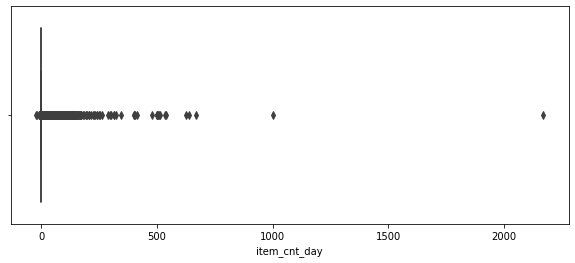

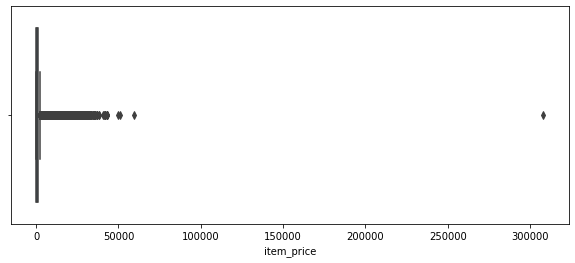

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(sales_train_df.item_cnt_day)

plt.figure(figsize=(10,4))
sns.boxplot(sales_train_df.item_price)

In [ ]:
sales_train_df = sales_train_df[sales_train_df.item_price<100000]
sales_train_df = sales_train_df[sales_train_df.item_cnt_day<1000]
sales_train_df.shape

(2935846, 6)

In [ ]:
#check if there are negative prices
sales_train_df[sales_train_df.item_price<0].item_price = sales_train_df.item_price.median()
sales_train_df[sales_train_df.item_price<0]

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [ ]:
#replace with item price with median price for the specific shop and month
median = sales_train_df[(sales_train_df.shop_id==32)&(sales_train_df.item_id==2973)&(sales_train_df.date_block_num==4)&(sales_train_df.item_price>0)].item_price.median()
sales_train_df.loc[sales_train_df.item_price<0, 'item_price'] = median
sales_train_df[sales_train_df.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [ ]:
# Removing duplicates from Sales train dataset
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']
sales_train_df.duplicated(subset=subset).value_counts()

False    2935822
True          24
dtype: int64

In [ ]:
sales_train_df.drop_duplicates(subset=subset,inplace=True)

In [ ]:
sales_train_df['revenue'] = sales_train_df.item_cnt_day*sales_train_df.item_price

### Feature engineering
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

In [ ]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train_df[sales_train_df.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
matrix.date_block_num.max()

33

In [ ]:
#matrix.to_csv("shop_items_comb_per_month.csv")
#matrix=pd.read_csv("shop_items_comb_per_month.csv")
#matrix[matrix.date_block_num==0]

Aggregate train set by shop/item pairs to calculate target aggregates, then clip(0,20) target value. This way train target will be similar to the test predictions.

In [ ]:
cols = ['date_block_num','shop_id','item_id']
train_grouped_df = sales_train_df.groupby(cols).item_cnt_day.sum().reset_index()
train_grouped_df.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=True)

matrix = pd.merge(matrix, train_grouped_df, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [ ]:
#Add test set to matrix to add the features to both data sets
test_df['date_block_num'] = 34
matrix = pd.concat([matrix, test_df], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)

In [ ]:
#function for creating lagged features
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
#Add lag features of item_cnt_month for 12 months
matrix= lag_feature(matrix, range(1,13), 'item_cnt_month')
print(matrix.head())


   date_block_num  shop_id  ...  item_cnt_month_lag_11  item_cnt_month_lag_12
0               0        2  ...                    NaN                    NaN
1               0        2  ...                    NaN                    NaN
2               0        2  ...                    NaN                    NaN
3               0        2  ...                    NaN                    NaN
4               0        2  ...                    NaN                    NaN

[5 rows x 17 columns]


In [ ]:
#join items to get the category id for every item
matrix = matrix.merge(items_merged_df[['item_id', 'item_category_id','main_category_ord', 'subcategory_ord']], how='left', on='item_id')
matrix = matrix.merge(shops_df[['shop_id', 'city_ord']], how='left', on='shop_id')
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_4', 'item_cnt_month_lag_5', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_7', 'item_cnt_month_lag_8', 'item_cnt_month_lag_9',
       'item_cnt_month_lag_10', 'item_cnt_month_lag_11',
       'item_cnt_month_lag_12', 'item_category_id', 'main_category_ord',
       'subcategory_ord', 'city_ord'],
      dtype='object')

In [ ]:
#function to find the average of a lagged for feature for the 2nd and 3rd trimester
def avg_trimester(df,col):
    lag_2nd_trimester = [col+'_lag_4',col+'_lag_5',col+'_lag_6']
    lag_3rd_trimester = [col+'_lag_7',col+'_lag_8',col+'_lag_9']
    #lag_4th_trimester = [col+'_lag_10',col+'_lag_11',col+'_lag_12']
    df[col+'_avg_lag_2nd_trimester'] = matrix[lag_2nd_trimester].mean(axis=1)
    df[col+'_avg_lag_3rd_trimester'] = matrix[lag_3rd_trimester].mean(axis=1)
    #df[col+'avg_lag_4th_trimester'] = matrix[lag_4th_trimester].mean(axis=1)
    df.drop([col+'_lag_4', col+'_lag_5',col+'_lag_6', col+'_lag_7',col+'_lag_8',col+'_lag_9', col+'_lag_10',col+'_lag_11'], axis=1, inplace=True)
    return df


matrix = avg_trimester(matrix, 'item_cnt_month')

/usr/local/lib/python3.6/dist-packages/pandas/core/nanops.py:116: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


### Mean Encoding
Added average item count per month and per month and store, for the previous three months, the 2nd and third semester and the 12th lag month. Also added the 1 month lag for average item count per city, category, main_category, and sub category.

In [ ]:
matrix['date_item_AIC'] = matrix.groupby(['date_block_num', 'item_id'])['item_cnt_month'].transform('mean')
matrix['date_item_AIC'] = matrix['date_item_AIC'].astype(np.float16)
matrix = lag_feature(matrix, range(1,13), 'date_item_AIC')
matrix.drop(['date_item_AIC'], axis=1, inplace=True)
matrix = avg_trimester(matrix, 'date_item_AIC')

/usr/local/lib/python3.6/dist-packages/pandas/core/nanops.py:116: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


In [ ]:
matrix['date_shop_AIC'] = matrix.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].transform('mean')
matrix['date_shop_AIC'] = matrix['date_shop_AIC'].astype(np.float16)
matrix = lag_feature(matrix, range(1,13), 'date_shop_AIC')
matrix.drop(['date_shop_AIC'], axis=1, inplace=True)
matrix = avg_trimester(matrix, 'date_shop_AIC')

/usr/local/lib/python3.6/dist-packages/pandas/core/nanops.py:116: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


In [ ]:
matrix['date_city_AIC'] = matrix.groupby(['date_block_num', 'city_ord'])['item_cnt_month'].transform('mean')
matrix['date_city_AIC'] = matrix['date_city_AIC'].astype(np.float16)
#matrix = lag_feature(matrix, range(1,13), 'date_city_AIC')
matrix = lag_feature(matrix, [1], 'date_city_AIC')
#matrix = avg_trimester(matrix, 'date_city_AIC')
matrix.drop(['date_city_AIC'], axis=1, inplace=True)

In [ ]:
matrix['date_category_AIC'] = matrix.groupby(['date_block_num', 'item_category_id'])['item_cnt_month'].transform('mean')
matrix['date_category_AIC'] = matrix['date_category_AIC'].astype(np.float16)
#matrix = lag_feature(matrix, range(1,13), 'date_category_AIC')
matrix = lag_feature(matrix, [1], 'date_category_AIC')
#matrix = avg_trimester(matrix, 'date_category_AIC')
matrix.drop(['date_category_AIC'], axis=1, inplace=True)

In [ ]:
matrix['date_main_category_AIC'] = matrix.groupby(['date_block_num', 'main_category_ord'])['item_cnt_month'].transform('mean')
matrix['date_main_category_AIC'] = matrix['date_main_category_AIC'].astype(np.float16)
#matrix = lag_feature(matrix, range(1,13), 'date_main_category_AIC')
matrix = lag_feature(matrix, [1], 'date_main_category_AIC')
#matrix = avg_trimester(matrix, 'date_main_category_AIC')
matrix.drop(['date_main_category_AIC'], axis=1, inplace=True)

In [ ]:
matrix['date_sub_category_AIC'] = matrix.groupby(['date_block_num', 'subcategory_ord'])['item_cnt_month'].transform('mean')
matrix['date_sub_category_AIC'] = matrix['date_sub_category_AIC'].astype(np.float16)
#matrix = lag_feature(matrix, range(1,13), 'date_sub_category_AIC')
matrix = lag_feature(matrix, [1], 'date_sub_category_AIC')
#matrix = avg_trimester(matrix, 'date_sub_category_AIC')
matrix.drop(['date_sub_category_AIC'], axis=1, inplace=True)

### Price Features
Used the average item price and revenue per store

In [ ]:
group = sales_train_df.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

matrix = lag_feature(matrix, range(1,4), 'date_item_avg_item_price')
matrix.drop(['date_item_avg_item_price'], axis=1, inplace=True)
del group

In [ ]:
group = sales_train_df.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)
matrix = lag_feature(matrix, [1], 'date_shop_revenue')
matrix.drop(['date_shop_revenue'], axis=1, inplace=True)
del group

In [ ]:
#added month and days of the month
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [ ]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_12', 'item_category_id', 'main_category_ord',
       'subcategory_ord', 'city_ord', 'item_cnt_month_avg_lag_2nd_trimester',
       'item_cnt_month_avg_lag_3rd_trimester', 'date_item_AIC_lag_1',
       'date_item_AIC_lag_2', 'date_item_AIC_lag_3', 'date_item_AIC_lag_12',
       'date_item_AIC_avg_lag_2nd_trimester',
       'date_item_AIC_avg_lag_3rd_trimester', 'date_shop_AIC_lag_1',
       'date_shop_AIC_lag_2', 'date_shop_AIC_lag_3', 'date_shop_AIC_lag_12',
       'date_shop_AIC_avg_lag_2nd_trimester',
       'date_shop_AIC_avg_lag_3rd_trimester', 'date_city_AIC_lag_1',
       'date_category_AIC_lag_1', 'date_main_category_AIC_lag_1',
       'date_sub_category_AIC_lag_1', 'date_item_avg_item_price_lag_1',
       'date_item_avg_item_price_lag_2', 'date_item_avg_item_price_lag_3',
       'date_shop_revenue_lag_1'

In [ ]:
#matrix.to_csv('mean_encondings_and_price.csv')
#matrix = pd.read_csv('mean_encondings_and_price.csv')
matrix = matrix[matrix.date_block_num > 11]
#matrix.to_csv('mean_encondings_and_price.csv')

In [ ]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [ ]:
#matrix=pd.read_csv('matrix_mean_encoded_tri.csv')
#matrix[matrix.date_block_num==22].head(50)

In [ ]:
#Separate data for mean encodings building
X_train = matrix[matrix.date_block_num<33].drop(['item_cnt_month'], axis=1)
y_train = matrix[matrix.date_block_num<33].item_cnt_month
X_valid = matrix[matrix.date_block_num==33].drop(['item_cnt_month'], axis=1)
y_valid = matrix[matrix.date_block_num==33].item_cnt_month
X_test = matrix[matrix.date_block_num==34].drop(['item_cnt_month'], axis=1)

pickle.dump(X_train, open("X_train.pickle.dat", "wb"))
pickle.dump(y_train, open("y_train.pickle.dat", "wb"))
pickle.dump(X_valid, open("X_valid.pickle.dat", "wb"))
pickle.dump(y_valid, open("y_valid.pickle.dat", "wb"))
pickle.dump(X_test, open("X_test.pickle.dat", "wb"))

In [ ]:
del matrix
del sales_train_df
del test_df
del items_df
del shops_df
del categories_df
del train_grouped_df
del items_merged_df
import gc
gc.collect();


### Training
6 XGBoost models are trained changing the depth and learning rate, the models and predictions are saved to be used in an ensemble 

In [10]:
X_train = pd.read_pickle('X_train.pickle.dat')
y_train = pd.read_pickle('y_train.pickle.dat')
X_valid = pd.read_pickle('X_valid.pickle.dat')
y_valid = pd.read_pickle('y_valid.pickle.dat')
X_test = pd.read_pickle('X_test.pickle.dat')

FileNotFoundError: ignored

In [ ]:
def train_models(depths, etas, X_train, y_train, X_valid, y_valid):
  i=0
  for depth in depths:
    for eta in etas:
      model = XGBRegressor(
        max_depth=depth,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=eta,    
        seed=42)

      model.fit(
          X_train, 
          y_train, 
          eval_metric="rmse", 
          eval_set=[(X_train, y_train), (X_valid, y_valid)], 
          verbose=True, 
          early_stopping_rounds = 10)
      
      y_pred = model.predict(X_valid).clip(0, 20)
      y_test = model.predict(X_test).clip(0, 20)
      pickle.dump(model, open("model_xgb_" + str(i)+ ".pickle.dat", "wb"))
      pickle.dump(y_pred, open("y_pred_xgb_"+str(i)+".pickle.dat", "wb"))
      pickle.dump(y_test, open("y_test_xgb_"+str(i)+".pickle.dat", "wb"))
      i += 1 
      del model
      del y_pred
      del y_test

In [ ]:
train_models([6,8,10], [0.2,0.3], X_train, y_train, X_valid, y_valid)

### Ensembling

In [4]:
#Load y_pred for every model, but given that the paremeter eta doesn't change the loss I will only use three models
meta_features = pd.DataFrame()
for i in range(0,3):
  meta_features['pred' + str(i)] = pickle.load(open('y_pred_xgb_' +  str(i*2) +'.pickle.dat', 'rb'))
meta_features.head()

,pred0,pred1,pred2
0,0.015576,0.028306,0.022855
1,0.079511,0.057144,0.034990
2,0.229569,0.240479,0.261573
3,0.241657,0.270879,0.264782
4,0.014758,0.011575,0.010676


In [5]:
y_valid = pickle.load(open('y_valid.pickle.dat', 'rb'))

In [14]:
meta_model = XGBRegressor(
    max_depth=4,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=7)

meta_model.fit(
    meta_features, 
    y_valid, 
    eval_metric="rmse",
    eval_set=[(meta_features, y_valid)],
    verbose=True, 
    early_stopping_rounds = 10)

[14:07:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.12206
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08948
[2]	validation_0-rmse:1.06191
[3]	validation_0-rmse:1.03965
[4]	validation_0-rmse:1.0202
[5]	validation_0-rmse:1.0045
[6]	validation_0-rmse:0.991656
[7]	validation_0-rmse:0.980209
[8]	validation_0-rmse:0.971223
[9]	validation_0-rmse:0.9637
[10]	validation_0-rmse:0.95723
[11]	validation_0-rmse:0.951784
[12]	validation_0-rmse:0.947697
[13]	validation_0-rmse:0.943575
[14]	validation_0-rmse:0.940186
[15]	validation_0-rmse:0.937643
[16]	validation_0-rmse:0.935268
[17]	validation_0-rmse:0.933281
[18]	validation_0-rmse:0.931683
[19]	validation_0-rmse:0.930539
[20]	validation_0-rmse:0.929584
[21]	validation_0-rmse:0.928422
[22]	validation_0-rmse:0.927431
[23]	validation_0-rmse:0.926752
[24]	validation_0-rmse:0.926193
[25]	validation_0-rmse:0.9257

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=7, silent=None,
             subsample=0.8, verbosity=1)

In [18]:
model = meta_model

meta_features_test = pd.DataFrame()
for i in range(0,3):
  meta_features_test['pred' + str(i)] = pickle.load(open('y_test_xgb_' +  str(i*2) +'.pickle.dat', 'rb'))
meta_features_test.head()

y_test = model.predict(meta_features_test).clip(0, 20)

test_df = pd.read_csv('test.csv')
submission = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": y_test
})
submission.to_csv('ensemble.csv', index=False)

In [ ]:
"""def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))"""

SyntaxError: invalid syntax (<ipython-input-40-8f5aadda6d88>, line 1)